In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import math
import time

%matplotlib qt

In [4]:
def camCalib():
    objpoints = [] # 3d points in real world space
    imgpoints = [] # 2d points in image plane.
    chessboards = glob.glob('camera_cal/calibration*.jpg')
    op=np.zeros((6*9,3),np.float32)
    op[:,:2]=np.mgrid[0:9,0:6].T.reshape(-1,2)
    counter=0
    for board in chessboards:
        counter+=1
        img=mpimg.imread(board)
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
        if ret==True:
            imgpoints.append(corners)
            objpoints.append(op)
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
       

    ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

    return mtx, dist

In [5]:
def undistortIMG(img, mtx, dist):
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    return dst

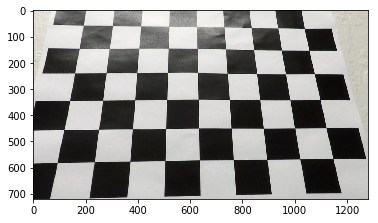

In [6]:
img=mpimg.imread('camera_cal/calibration3.jpg')
plt.imshow(img)


mtx, dist=camCalib()
dst=undistortIMG(img, mtx, dist)
plt.imshow(dst)

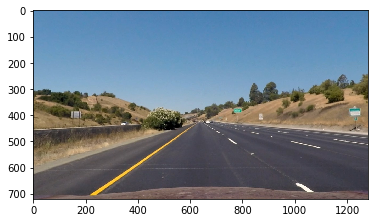

In [7]:
testpic=mpimg.imread('test_images/straight_lines1.jpg')

testundist=undistortIMG(testpic,mtx,dist)

plt.imshow(testundist)

In [8]:
# Create Binary Picture
def createBIN(img, sthresh=(90, 255), sxthresh=(50, 255), hthresh=(15,100)):
    
    #img=cv2.GaussianBlur(img, (3, 3), 0)
    
    #different channels for later handling
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    s_channel = hls[:,:,2]
    l_channel = hls[:,:,1]
    h_channel = hls[:,:,0]
    
    #sobel derivative
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0)
    abs_sobelx = np.absolute(sobelx) 
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sxthresh[0]) & (scaled_sobel <= sxthresh[1])] = 1
    
    # saturation threshold
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= sthresh[0]) & (s_channel <= sthresh[1])] = 1
    # visualize output not needed anymore to speed up
    #stackoutput = np.dstack(( np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    #hue threshold
    h_binary= np.zeros_like(h_channel)
    h_binary[(h_channel > hthresh[0]) & (h_channel <= hthresh[1])] = 1
    h_binary[(h_channel > hthresh[0]) & (h_channel <= hthresh[1])] = 1
    
    binary_output = np.zeros_like(sxbinary)
    binary_output[(s_binary == 1) | (sxbinary == 1) | (h_binary == 1)] = 1
    
    #binary_output = np.zeros_like(s_channel)
    #binary_output[(s_channel > thresh[0]) & (s_channel <= thresh[1])] = 1
    
    
    
    
    return binary_output



In [9]:
#define M Matrix and its inverse once
#i found the values manully by fitting in a polygon on the original picture
def warpParameters():
    img=mpimg.imread('test_images/straight_lines2.jpg')
    undist=undistortIMG(img, mtx, dist)
    imshape=undist.shape
    src=np.float32([[(315,imshape[0]-70),(imshape[1]/2-102, imshape[0]/2+130), (imshape[1]/2+115, imshape[0]/2+130), (imshape[1]-278,imshape[0]-70)]])
    dst=np.float32([[(315,imshape[0]-70),(315, imshape[0]/2+130), (imshape[1]-278, imshape[0]/2+130), (imshape[1]-278,imshape[0]-70)]])
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    cv2.polylines(undist,np.int32(src),1,[0,0,255],4,8)
    cv2.polylines(undist,np.int32(dst),1,[255,0,0],4,8)
    

    return M,Minv,src,dst


In [10]:
def warpIMG(img,M):
    img_size=(img.shape[1],img.shape[0])
    warpedIMG = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
    return warpedIMG

In [11]:
def unwarpIMG(img,Minv):
    img_size=(img.shape[1],img.shape[0])
    unwarpedIMG = cv2.warpPerspective(img, Minv, img_size, flags=cv2.INTER_LINEAR)
    return unwarpedIMG

In [12]:
#globals
mtx=[]
dist=[]
M=[]
Minv=[]
left_fit=[]
right_fit=[]
left_fitxPrev=[]
right_fitxPrev=[]
runCounter=0
rxp=[]
ryp=[]
correctionCount=0
processCount=0
lowerRighty=[]
lowerRightx=[]
lowerRightAve=0
lowerLefty=[]
lowerLeftx=[]
lowerLeftAve=0
upperRighty=[]
upperRightx=[]
upperRightAve=0
historyCount=0

In [13]:
def findFirstLanes(warpedIMG):
    # Take a histogram of the bottom half of the image
    histogram = np.sum(warpedIMG[warpedIMG.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and visualize the result
    out_img = np.dstack((warpedIMG, warpedIMG, warpedIMG))
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint

    # HYPERPARAMETERS
    
    # HYPERPARAMETERS
    # Choose the number of sliding windows
    nwindows = 9
    # Set the width of the windows +/- margin
    margin = 150
    # Set minimum number of pixels found to recenter window
    minpix = 70

    # Set height of windows - based on nwindows above and image shape
    window_height = np.int(warpedIMG.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = warpedIMG.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = warpedIMG.shape[0] - (window+1)*window_height
        win_y_high = warpedIMG.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),
        (win_xleft_high,win_y_high),(0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),
        (win_xright_high,win_y_high),(0,255,0), 2) 
        
        # Identify the nonzero pixels in x and y within the window #
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) &  (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xright_low) &  (nonzerox < win_xright_high)).nonzero()[0]
        
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]

    return leftx, lefty, rightx, righty, out_img

In [14]:
def fitPoly(warpedIMG):
        # Find our lane pixels first
    global left_fitxPrev
    global right_fitxPrev
    global rxp
    global ryp
    leftx, lefty, rightx, righty, out_img = findFirstLanes(warpedIMG)

    # Fit a second order polynomial to each using `np.polyfit`
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    # Generate x and y values for plotting
    ploty = np.linspace(0, warpedIMG.shape[0]-1, warpedIMG.shape[0] )
    try:
        left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
        right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty
    left_fitxPrev=left_fitx
    right_fitxPrev=right_fitx
    ## Visualization ##
    # Colors in the left and right lane regions
    out_img[lefty, leftx] = [255, 0, 0]
    out_img[righty, rightx] = [0, 0, 255]

    rxp=rightx
    ryp=righty
    return out_img, left_fitx, right_fitx,ploty,left_fit,right_fit

In [15]:
ldev=[0,0,0]
rdev=[0,0,0]
Rfirst=[]
Rsecond=[]
Rthird=[]
Lfirst=[]
Lsecond=[]
Lthird=[]

devCount=0
#### for following frames
def fitPolyPP(img_shape, leftx, lefty, rightx, righty):
     ### TO-DO: Fit a second order polynomial to each with np.polyfit() ###
    global left_fit
    global right_fit
    global ldev
    global rdev
    global devCount
    global Rfirst
    global Rsecond
    global Rthird
    global Lfirst
    global Lsecond
    global Lthird
    global ryp
    global rxp
    global left_fitxPrev
    global right_fitxPrev
    #print(rightx)
    lst=[]
    foundit=False
#    for index,item in enumerate(righty):
#        #print(index)
#        #print(item)
#        if index>0:
#            if item==righty[index-1]:
#                if foundit==False:
#                   lst.append(rightx[index-1])                
#                lst.append(rightx[index])
#                foundit=True
#            else:
#                foundit=False
#                i=len(lst)
#                if i>0:
#                    AVE=int(sum(lst)/i)
#                    rightx[index-1]=AVE
#                while (i>1):
#                    rightx[index-i]=AVE
#                    i-=1
#
#
#
#                #print(lst)
#                lst=[]            

    
    try:
        lpr=left_fit
        rpr=right_fit

        #print(rightx)
        #print(righty)

        
        
        left_fit = np.polyfit(lefty, leftx, 2)
        right_fit = np.polyfit(righty, rightx, 2)
        
        
        
        
        #print("right:")
        #print(right_fit)
        #print("left:")
        #print(left_fit)
        #print("change to previous:")
        #Rdev=rpr-right_fit
        #Ldev=lpr-left_fit
        #print(abs(rpr-right_fit))
        #print(abs(lpr-left_fit))
        #rdev+=abs(rpr-right_fit)
        #ldev+=abs(lpr-left_fit)
        #devCount+=1
        #Rfirst.append(Rdev[0])
        #Rsecond.append(Rdev[1])
        #Rthird.append(Rdev[2])
        #Lfirst.append(Ldev[0])
        #Lsecond.append(Ldev[1])
        #Lthird.append(Ldev[2])
        #if (abs(Rdev[1])>0.35):
        #    if np.sign(Rdev[1])==1:
        #        right_fit[1]=rpr[1]-0.35
        #    else:
        #        right_fit[1]=rpr[1]+0.35               
        #    print("hi right")
        #if (abs(Ldev[1])>0.4):
        #    #left_fit=lpr
        #    print("hi left")

        #print("next")
        
    except:
        print("empty fit")
            
    # Generate x and y values for plotting
    ploty = np.linspace(0, img_shape[0]-1, img_shape[0])
    ### TO-DO: Calc both polynomials using ploty, left_fit and right_fit ###
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    #print(left_fitx-left_fitxPrev)
    #print(right_fitx-right_fitxPrev)
    #diffL=(left_fitxPrev-left_fitx)

    #diffR=(right_fitxPrev-right_fitx) 
    #print(diffR[0])
    
    #if abs(diffR[0])>15:
    #k=len(righty)
    #k=int(k*0.01)
    #print("K:")
    #print(k)
    #pk=np.arange(0,k)

    #print("PK:")
    #print(pk)

    #print("fst:")
    #print(len(righty))
    #righty=np.delete(righty,pk)
    #print("sec:")
    #print(len(righty))
    #rightx=np.delete(rightx,pk)
    #nk=np.arange(len(righty)-k,len(righty))
    #print("NK:")
    #print(nk)
    #righty=np.delete(righty,nk)
    #rightx=np.delete(rightx,nk)
    #print("third:")
    #print(len(righty))
    #right_fit = np.polyfit(righty, rightx, 2)
    #right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
        
    #for index,item in enumerate(diffR):
    #    if item>12:
    #        #right_fitx[index]=right_fitxPrev[index]-40
    #        True
    #    if item<-12:
    #        True
            #right_fitx[index]=right_fitxPrev[index]+40

    #left_fit = np.polyfit(ploty, leftx, 2)
    #right_fit = np.polyfit(ploty, right_fitx, 2)
        

    
    
    rxp=rightx
    ryp=righty
    return left_fitx, right_fitx, ploty

In [16]:
def search_around_poly(warpedIMG):
    # HYPERPARAMETER
    # Choose the width of the margin around the previous polynomial to search
    # The quiz grader expects 100 here, but feel free to tune on your own!
    #45 sehr gut
    margin = 40
    #16 waren die probleme
    global left_fitxPrev
    global right_fitxPrev
    global processCount
    global left_fit
    global right_fit
    global correctionCount
    global lowerRighty
    global lowerRightx
    global lowerRightAve
    global lowerLefty
    global lowerLeftx
    global lowerLeftAve
    global upperRighty
    global upperRightx
    global upperRightAve

    global historyCount
    # Grab activated pixels
    nonzero = warpedIMG.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    ### TO-DO: Set the area of search based on activated x-values ###
    ### within the +/- margin of our polynomial function ###
    ### Hint: consider the window areas for the similarly named variables ###
    ### in the previous quiz, but change the windows to our new search area ###
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + 
                    left_fit[2] - margin)) & (nonzerox < (left_fit[0]*(nonzeroy**2) + 
                    left_fit[1]*nonzeroy + left_fit[2] + margin)))
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + 
                    right_fit[2] - margin)) & (nonzerox < (right_fit[0]*(nonzeroy**2) + 
                    right_fit[1]*nonzeroy + right_fit[2] + margin)))
    
    # Again, extract left and right line pixel positions

    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    #get the current values
    valsR=np.vstack((righty,rightx))
    valsL=np.vstack((lefty,leftx))
    #grab the lower part of the screen
    indiceLowerRight=valsR[0]>645
    indiceLowerLeft=valsL[0]>645
    if historyCount >10:
        #reject outliers
        indiceLowerRightAVE=(valsR[1]<lowerRightAve+35) & (valsR[1]>lowerRightAve-35)
        indiceLowerLeftAVE=(valsL[1]<lowerLeftAve+35) & (valsL[1]>lowerLeftAve-35) 
        #combine outlier rejection and only bottom values for the current values
        lowerLeftxCurr=leftx[indiceLowerLeft&indiceLowerLeftAVE]
        lowerLeftyCurr=lefty[indiceLowerLeft&indiceLowerLeftAVE]
        lowerRightxCurr=rightx[indiceLowerRight&indiceLowerRightAVE]
        lowerRightyCurr=righty[indiceLowerRight&indiceLowerRightAVE]
    else:
  
        #first grab the current findings if counter is below 11 then we don't have an average to compare yet, hence this is here without it
        #lowerLeft
        lowerLeftxCurr=leftx[indiceLowerLeft]
        lowerLeftyCurr=lefty[indiceLowerLeft]
        #lowerRight
        lowerRightxCurr=rightx[indiceLowerRight]
        lowerRightyCurr=righty[indiceLowerRight]

        
    #then add the history to the current findings
    #lowerLeft
    leftx=np.hstack((leftx,lowerLeftx))
    lefty=np.hstack((lefty,lowerLefty))
    #lowerRight
    rightx=np.hstack((rightx,lowerRightx))
    righty=np.hstack((righty,lowerRighty))
    
    #then ad the previously found to the history (withot the history that was added beforehand)
    #lowerLeft
    lowerLefty=np.hstack((lowerLeftyCurr,lowerLefty))
    lowerLeftx=np.hstack((lowerLeftxCurr,lowerLeftx))
    #lowerRight
    lowerRighty=np.hstack((lowerRightyCurr,lowerRighty))
    lowerRightx=np.hstack((lowerRightxCurr,lowerRightx))    
    #keep the history to the last X frames only and delete the old data
    #lowerLeft
    if historyCount >20:
        lowerLefty=np.resize(lowerLefty, lowerLefty.size - lowerLeftyCurr.size)
        lowerLeftx=np.resize(lowerLeftx, lowerLeftx.size - lowerLeftxCurr.size)
        lowerLeftAve=int(np.average(lowerLeftx))
        lowerRighty=np.resize(lowerRighty, lowerRighty.size - lowerRightyCurr.size)
        lowerRightx=np.resize(lowerRightx, lowerRightx.size - lowerRightxCurr.size)
        lowerRightAve=int(np.average(lowerRightx))

    
    #update counter for history tracking
    historyCount+=1
    #print("upperRighty")    
    #print(len(upperRighty))
    #print("lowerRighty") 
    #print(len(lowerRighty))
    #print("Righty") 
    #print(len(righty))    
    
    #print(lowerRighty)
    #print(len(lowerRighty))
    #print(lowerRightx)
    #print(len(lowerRightx))

    # Fit new polynomials
    left_fitx, right_fitx, ploty = fitPolyPP(warpedIMG.shape, leftx, lefty, rightx, righty)
    
    #n=int(len(left_fitx)/5)
    #fehlerLeftOben=left_fitx[:n]
    #fehlerLeftUnten=left_fitx[4*n:]
    #SQ=0
    #step=3

    for index,item in enumerate(left_fitx):
        if item>right_fitx[index]:
            print("crossed")
            #print("the lanes crossed - something is wrong here at%d" % processCount)
            #left_fitx=left_fitxPrev
            #right_fitx=right_fitxPrev
            
    
#    for index, pixel in enumerate(left_fitx):
#        #print(index)
#        if step>(left_fitxPrev[index]-pixel):
#            left_fitx[index]=left_fitxPrev[index]-step
#
#            
#        if (left_fitxPrev[index]-pixel)<(-step):
#            left_fitx[index]=left_fitxPrev[index]+step
#           
#    for index, pixel in enumerate(right_fitx):
#        #print(index)
#        if step>(right_fitxPrev[index]-pixel):
#            right_fitx[index]=right_fitxPrev[index]-step
#           
#        if (right_fitxPrev[index]-pixel)<(-step):
#            right_fitx[index]=right_fitxPrev[index]+step
#            
#    left_fitx, right_fitx, ploty = fitPolyPP(warpedIMG.shape, left_fitx, ploty, right_fitx, ploty)


        #print(left_fitxPrev[index])
        #print(pixel)


        
   
    #print(len(left_fitx))
    #print(fehlerLeftAnfang)
    #print(fehlerLeftEnde)
    diffL=(abs(left_fitxPrev-left_fitx))
    diffR=(abs(right_fitxPrev-right_fitx))
    #print(np.amax(diffL))
    #print(np.amax(diffL))
    diff=50
    if diffL[0]>diff or diffL[719]>diff or diffR[0]>diff or diffR[719]>diff:
        correctionCount+=1
        print(processCount)
        #out_img, left_fitx, right_fitx,ploty,left_fit,right_fit = fitPoly(warpedIMG)
       
    
    
    ## Visualization ##
    # Create an image to draw on and an image to show the selection window
    out_img = np.dstack((warpedIMG, warpedIMG, warpedIMG))*255
    window_img = np.zeros_like(out_img)
    # Color in left and right line pixels
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

    # Generate a polygon to illustrate the search window area
    # And recast the x and y points into usable format for cv2.fillPoly()
    left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
    left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, 
                              ploty])))])
    left_line_pts = np.hstack((left_line_window1, left_line_window2))
    right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
    right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, 
                              ploty])))])
    right_line_pts = np.hstack((right_line_window1, right_line_window2))
    
    ###fill center
    left_line_center = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    left_line_center = np.hstack((left_line_center))
    right_line_center = np.array([np.transpose(np.vstack([right_fitx, ploty]))])
    right_line_center = np.hstack((right_line_center))
    right_line_center = np.flipud(right_line_center)
    center_pts = np.concatenate((left_line_center, right_line_center))
    # Draw the lane onto the warped blank image
    #cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
    #cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
    LeftLine=np.vstack((left_fitx,ploty)).T
    RightLine=np.vstack((right_fitx,ploty)).T
    cv2.polylines(window_img,np.int32([LeftLine]),False,(255,0,0),25)
    cv2.polylines(window_img,np.int32([RightLine]),False,(0,0,255),25)
    cv2.fillPoly(window_img, np.int_([center_pts]), (0,25, 0))
    result = cv2.addWeighted(out_img, 0, window_img, 1, 0)

    left_fitxPrev=left_fitx
    right_fitxPrev=right_fitx
    xm_per_pix = 3.7/720
    
    center=(right_fitx[int(np.max(ploty))]-left_fitx[int(np.max(ploty))])/2

    distance=(center-(window_img.shape[1]/2))*xm_per_pix

    
    return result, left_fitx,right_fitx, ploty, distance

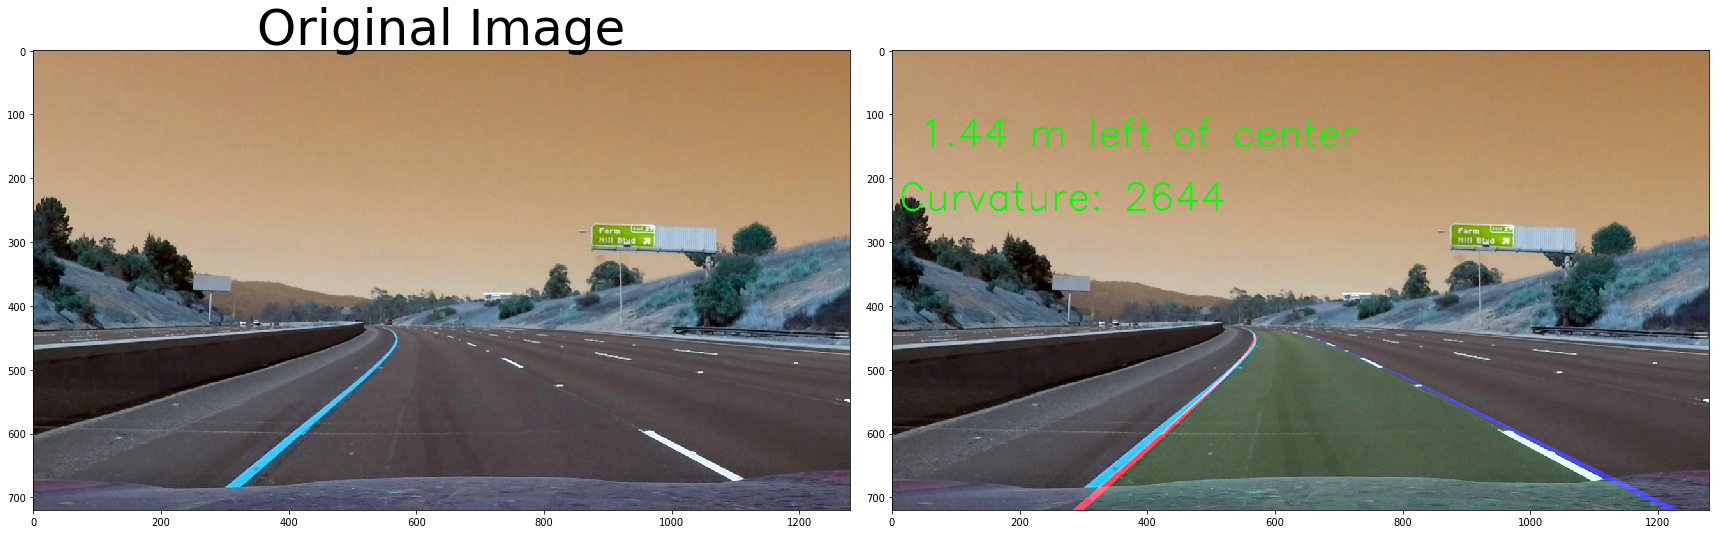

In [21]:



#main pipeline
#img=mpimg.imread('test_images/test6.jpg')
#plt.imshow(img)
def pipeLineFirst(img):
    global mtx
    global dist
    global M
    global Minv
    global left_fit
    global right_fit
    mtx, dist=camCalib()
    undist=undistortIMG(img, mtx, dist)
    BIN=createBIN(undist, sthresh=(85, 255), sxthresh=(40, 255), hthresh=(40,100))
    M,Minv,src,dst=warpParameters()

    warpedIMG=warpIMG(BIN,M)

    out_img, left_fitx, right_fitx,ploty, left_fit, right_fit=fitPoly(warpedIMG)
    



def pipeLineConti(img, mtx, dist, M, Minv, left_fit, right_fit):

    ym_per_pix=30/720
    xm_per_pix = 3.7/720    
    undist=undistortIMG(img, mtx, dist)
    #110,35, (40,95)
    BIN=createBIN(undist, sthresh=(130, 255), sxthresh=(35, 255), hthresh=(40,95))

    warpedIMG=warpIMG(BIN,M)

    result, left_fitx,right_fitx, ploty, distance = search_around_poly(warpedIMG)

    result2=unwarpIMG(result,Minv)
    result3 = cv2.addWeighted(img, 1, result2, 1, 0)
    
    y_eval = np.max(ploty)
    left_curverad = ((1 + (2*left_fit[0]*y_eval*ym_per_pix + left_fit[1])**2)**1.5) / np.absolute(2*left_fit[0])
    right_curverad = ((1 + (2*right_fit[0]*y_eval*ym_per_pix + right_fit[1])**2)**1.5) / np.absolute(2*right_fit[0])
    #print(left_curverad)
    #print(right_curverad)
    f = cv2.FONT_HERSHEY_SIMPLEX
    result4=cv2.putText(result3, 'Curvature: %d' %right_curverad, (10,250), f, 2, (0, 255, 0), 2, cv2.LINE_AA)
    distanceStr=format(abs(distance), '.2f')

    if distance<=0:
        result4=cv2.putText(result4, ' %s m left of center' %distanceStr, (10,150), f, 2, (0, 255, 0), 2, cv2.LINE_AA)
    else:
        result4=cv2.putText(result4, 'Car is %s m to the right of center' %distanceStr, (10,550), f, 3, (0, 255, 0), 2, cv2.LINE_AA)
    

    return result4


#626,625
img2=cv2.imread('singleFrames/frame30.jpg')
img1=cv2.imread('singleFrames/frame29.jpg')
pipeLineFirst(img1)


test=pipeLineConti(img2, mtx, dist, M, Minv, left_fit, right_fit)



f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(img2)
ax1.set_title('Original Image', fontsize=50)

ax2.imshow(test, cmap='gray')
#ax2.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)




### TODO: Zu große abweichungen unterbinden
### radius und fahrezugposi

In [18]:
############################################################################
####Video to single Frames for input to the tested functions
############################################################################
vidcap = cv2.VideoCapture('project_video.mp4')
success,image = vidcap.read()

####internal variables for debugging
count = 0

####grab each frame and save it
while success:
    cv2.imwrite("singleFrames/frame%d.jpg" % count, image)     # save frame as JPEG file      
    success,image = vidcap.read()
    #plt.imshow(image)
    #PaintLanes(image)
    #print('Read a new frame: ', success)    
    count += 1
print(count)

1260


In [19]:
############################################################################
####Apply the pipeline (PaintLanes()) to all frames extraced
############################################################################

####reset globals before starting the pipeline

####

####internal variables for debugging
processCount=0
#count=1260

end_time=0
finalImage=pipeLineFirst(cv2.imread("singleFrames/frame%d.jpg" % processCount))
while (processCount<count):
    start_time = time.time()
    #print (processCount)
    finalImage=pipeLineConti(cv2.imread("singleFrames/frame%d.jpg" % processCount), mtx, dist, M, Minv, left_fit, right_fit)
    cv2.imwrite("singleFramesA/frame%d.jpg" % processCount, finalImage)
    processCount+=1
    end_time=end_time+(time.time() - start_time)
    #print (processCount)
print(processCount)
print(correctionCount)
#Rfirst.sort(reverse=True)
#Rsecond.sort(reverse=True)
#Rthird.sort(reverse=True)
#Lfirst.sort(reverse=True)
#Lsecond.sort(reverse=True)
#Lthird.sort(reverse=True)
#print(Rthird)
#print(Lthird)
print("---it took %s seconds on avarage---" % (end_time/processCount))

195
196
197
539
543
555
559
560
561
562
563
564
565
570
571
576
605
606
607
616
618
619
642
1002
1003
1004
1029
1031
1032
1035
1039
1047
1050
1260
33
---it took 0.1516432525619628 seconds on avarage---


In [20]:
# ####put altered (incl lane markings) frames back to video
############################################################################

####internal variables for debugging and Array to store frames
FrameArray = []
processCountVideo=0

while (processCountVideo<count):
    img = cv2.imread("singleFramesA/frame%d.jpg" % processCountVideo)
    height, width, layers = img.shape
    size = (width,height)
    FrameArray.append(img)
    processCountVideo+=1


out = cv2.VideoWriter('examples/project.mp4',cv2.VideoWriter_fourcc(*'MP4V'), 15, size)
 
for i in range(len(FrameArray)):
    out.write(FrameArray[i])
out.release()
print(processCountVideo)

1260
